# Problem 50

In [1]:
import urllib.request

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip'
urllib.request.urlretrieve(url, 'NewsAggregatorDataset.zip')

('NewsAggregatorDataset.zip', <http.client.HTTPMessage at 0x7fe3605aafa0>)

In [2]:
import zipfile

with zipfile.ZipFile('NewsAggregatorDataset.zip') as existing_zip:
    existing_zip.extractall('./NewsAggregatorDataset')

In [3]:
import pandas as pd

df = pd.read_table('./NewsAggregatorDataset/newsCorpora.csv', names=('ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'))

In [4]:
targets = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df = df[df['PUBLISHER'].isin(targets)]
df = df.sample(frac=1).reset_index(drop=True)
num_train = int(len(df)*0.8)
num_valid_and_test = int(len(df)*0.1)
df_train = df[0:num_train]
df_valid = df[num_train:num_train+num_valid_and_test]
df_test = df[num_train+num_valid_and_test:]

In [5]:
df_train.to_csv('train.txt', sep='\t')
df_valid.to_csv('valid.txt', sep='\t')
df_test.to_csv('test.txt', sep='\t')

In [6]:
print(len(df_train))
print(len(df_valid))
print(len(df_test))

10672
1334
1334


# Problem 51

In [7]:
import re
import string

def preprocess_text(s):
    trans_table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    s = s.translate(trans_table)
    s = s.lower()
    s = re.sub('[0-9]+', '0', s)
    s = re.sub('\s+', ' ', s)
    return s

df_train['TITLE'] = df_train['TITLE'].map(preprocess_text)
df_valid['TITLE'] = df_valid['TITLE'].map(preprocess_text)
df_test['TITLE'] = df_test['TITLE'].map(preprocess_text)

<ipython-input-7-4d5351b91d6c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TITLE'] = df_train['TITLE'].map(preprocess_text)
<ipython-input-7-4d5351b91d6c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['TITLE'] = df_valid['TITLE'].map(preprocess_text)
<ipython-input-7-4d5351b91d6c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, stop_words='english', ngram_range=(1, 2))
df_train_valid = pd.concat([df_train, df_valid])

X_train_valid = tfidf_vectorizer.fit_transform(df_train_valid['TITLE'])
X_test = tfidf_vectorizer.transform(df_test['TITLE'])

In [9]:
df_X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=tfidf_vectorizer.get_feature_names())
df_X_test = pd.DataFrame(X_test.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [10]:
df_X_train = df_X_train_valid[:len(df_train)]
df_X_valid = df_X_train_valid[len(df_train):]

In [11]:
# This cell takes long time
#df_X_train.to_csv('./train.feature.txt', sep='\t', index=False)
#df_X_valid.to_csv('./valid.feature.txt', sep='\t', index=False)
#df_X_test.to_csv('./test.feature.txt', sep='\t', index=False)

# Problem 52

In [12]:
from sklearn.linear_model import LogisticRegression

logi_regress = LogisticRegression(random_state=0)
logi_regress.fit(df_X_train, df_train['CATEGORY'])

/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

# Problem 53

In [13]:
import numpy as np

def predict_category(model, X):
    return (np.max(model.predict_proba(X), axis=1), model.predict(X))

predict_category(logi_regress, df_X_train)

(array([0.82772357, 0.83699212, 0.74376004, ..., 0.42438094, 0.58941473,
        0.89237751]),
 array(['e', 'b', 'b', ..., 'e', 'b', 'b'], dtype=object))

# Problem 54

In [14]:
from sklearn.metrics import accuracy_score

_, train_category_predicted = predict_category(logi_regress, df_X_train)
train_accuracy = accuracy_score(df_train['CATEGORY'], train_category_predicted)
print("train accuracy:", train_accuracy)
_, test_category_predicted = predict_category(logi_regress, df_X_test)
test_accuracy = accuracy_score(df_test['CATEGORY'], test_category_predicted)
print("test accuracy:", test_accuracy)

train accuracy: 0.951180659670165
test accuracy: 0.8860569715142429


# Problem 55

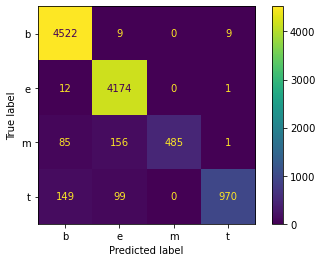

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

classes = sorted(list(set(train_category_predicted)))

conf_mat_train = confusion_matrix(df_train['CATEGORY'], train_category_predicted)
disp = ConfusionMatrixDisplay(conf_mat_train, display_labels=classes)
disp.plot()
plt.show()

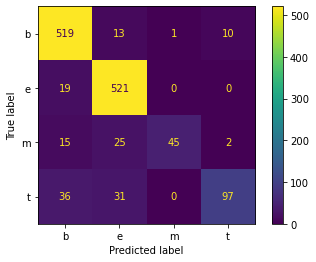

In [16]:
conf_mat_test = confusion_matrix(df_test['CATEGORY'], test_category_predicted)
disp = ConfusionMatrixDisplay(conf_mat_test, display_labels=classes)
disp.plot()
plt.show()

# Problem 56

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# precision
precision_category = precision_score(df_test['CATEGORY'], test_category_predicted, average=None, labels=['b', 'e', 't', 'm'])
precision_micro = precision_score(df_test['CATEGORY'], test_category_predicted, average='micro')
precision_macro = precision_score(df_test['CATEGORY'], test_category_predicted, average='macro')
print("Precision by category['b', 'e', 't', 'm'] = ", precision_category)
print("Precision by micro average = ", precision_micro)
print("Precision by micro average = ", precision_macro)

Precision by category['b', 'e', 't', 'm'] =  [0.8811545  0.88305085 0.88990826 0.97826087]
Precision by micro average =  0.8860569715142429
Precision by micro average =  0.9080936182636705


In [18]:
# recall
recall_category = recall_score(df_test['CATEGORY'], test_category_predicted, average=None, labels=['b', 'e', 't', 'm'])
recall_micro = recall_score(df_test['CATEGORY'], test_category_predicted, average='micro')
recall_macro = recall_score(df_test['CATEGORY'], test_category_predicted, average='macro')
print("Recall by category['b', 'e', 't', 'm'] = ", recall_category)
print("Recall by micro average = ", recall_micro)
print("Recall by micro average = ", recall_macro)

Recall by category['b', 'e', 't', 'm'] =  [0.9558011  0.96481481 0.59146341 0.51724138]
Recall by micro average =  0.8860569715142429
Recall by micro average =  0.7573301784329204


In [19]:
# F1
f1_category = f1_score(df_test['CATEGORY'], test_category_predicted, average=None, labels=['b', 'e', 't', 'm'])
f1_micro = f1_score(df_test['CATEGORY'], test_category_predicted, average='micro')
f1_macro = f1_score(df_test['CATEGORY'], test_category_predicted, average='macro')
print("F1 by category['b', 'e', 't', 'm'] = ", f1_category)
print("F1 by micro average = ", f1_micro)
print("F1 by micro average = ", f1_macro)

F1 by category['b', 'e', 't', 'm'] =  [0.91696113 0.92212389 0.71062271 0.67669173]
F1 by micro average =  0.8860569715142429
F1 by micro average =  0.8065998661233444


# Problem 57

In [20]:
features = df_X_train.columns.values
index = [i for i in range(1, 11)]
for category_name, coef in zip(logi_regress.classes_, logi_regress.coef_):
    print("For category {0}".format(category_name))
    best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['Importance best 10'], index=index).T
    worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['Importance worst 10'], index=index).T
    display(pd.concat([best10, worst10], axis=0))

For category b


,1,2,3,4,5,6,7,8,9,10
Importance best 10,stocks,update,china,fed,ecb,bank,euro,dollar,profit,ukraine
Importance worst 10,google,ebola,apple,facebook,star,video,study,kardashian,microsoft,drug


For category e


,1,2,3,4,5,6,7,8,9,10
Importance best 10,kardashian,star,chris,kim,movie,miley,cyrus,miley cyrus,wedding,beyonce
Importance worst 10,update,google,says,china,study,ceo,billion,gm,sales,apple


For category m


,1,2,3,4,5,6,7,8,9,10
Importance best 10,ebola,study,cancer,fda,drug,mers,cigarettes,health,virus,cdc
Importance worst 10,gm,google,apple,amazon,china,facebook,stocks,ceo,deal,buy


For category t


,1,2,3,4,5,6,7,8,9,10
Importance best 10,google,apple,facebook,microsoft,gm,climate,tesla,mobile,samsung,fcc
Importance worst 10,stocks,fed,ecb,drug,kardashian,cancer,ebola,shares,american,dollar


In [21]:
from tqdm import tqdm

result_accuracy = []
for reg_C in tqdm(np.logspace(-4, 6, 10, base=10)):
    logi_regress = LogisticRegression(random_state=0, C=reg_C, max_iter=1000)
    logi_regress.fit(df_X_train, df_train['CATEGORY'])
    
    _, train_pred = predict_category(logi_regress, df_X_train)
    _, valid_pred = predict_category(logi_regress, df_X_valid)
    _, test_pred = predict_category(logi_regress, df_X_test)
    
    train_accuracy = accuracy_score(df_train['CATEGORY'], train_pred)
    valid_accuracy = accuracy_score(df_valid['CATEGORY'], valid_pred)
    test_accuracy = accuracy_score(df_test['CATEGORY'], test_pred)
    
    result_accuracy.append([reg_C, train_accuracy, valid_accuracy, test_accuracy])

 80%|████████  | 8/10 [01:34<00:38, 19.37s/it]/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 90%|█████████ | 9/10 [02:24<00:28, 28.90s/it]/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

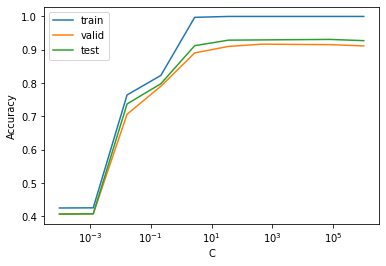

In [22]:
result_accuracy = np.array(result_accuracy).T
plt.plot(result_accuracy[0], result_accuracy[1], label='train')
plt.plot(result_accuracy[0], result_accuracy[2], label='valid')
plt.plot(result_accuracy[0], result_accuracy[3], label='test')
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

In [23]:
result_f1 = []
for reg_C in tqdm(np.logspace(-4, 6, 10, base=10)):
    logi_regress = LogisticRegression(random_state=0, C=reg_C, max_iter=1000)
    logi_regress.fit(df_X_train, df_train['CATEGORY'])
    
    _, train_pred = predict_category(logi_regress, df_X_train)
    _, valid_pred = predict_category(logi_regress, df_X_valid)
    _, test_pred = predict_category(logi_regress, df_X_test)
    
    train_f1 = f1_score(df_train['CATEGORY'], train_pred, average='micro')
    valid_f1 = f1_score(df_valid['CATEGORY'], valid_pred, average='micro')
    test_f1 = f1_score(df_test['CATEGORY'], test_pred, average='micro')
    
    result_f1.append([reg_C, train_f1, valid_f1, test_f1])

 80%|████████  | 8/10 [01:35<00:38, 19.47s/it]/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 90%|█████████ | 9/10 [02:25<00:29, 29.10s/it]/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

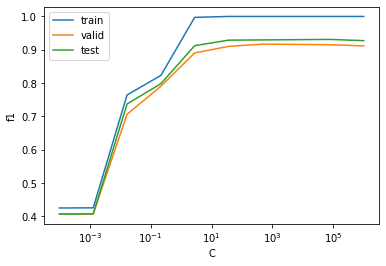

In [24]:
result_f1 = np.array(result_f1).T
plt.plot(result_f1[0], result_f1[1], label='train')
plt.plot(result_f1[0], result_f1[2], label='valid')
plt.plot(result_f1[0], result_f1[3], label='test')
plt.ylabel('f1')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

# Problem 59

In [32]:
import optuna
# Hyper-parameter optimization of C
def obj_logi_regress(trial):
    reg_C = trial.suggest_loguniform('reg_C', 1e-4, 1e6)
    logi_regress = LogisticRegression(random_state=0, C=reg_C, max_iter=500)
    logi_regress.fit(df_X_train, df_train['CATEGORY'])
    _, valid_pred = predict_category(logi_regress, df_X_valid)
    valid_accuracy = accuracy_score(df_valid['CATEGORY'], valid_pred)
    return valid_accuracy

In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(obj_logi_regress, n_jobs=2, n_trials=30)

[I 2022-01-23 21:34:23,460] A new study created in memory with name: no-name-0f9b6a7a-9e96-4dd9-9095-367c2b6a7ffe
/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/py

[I 2022-01-23 21:39:00,874] Trial 18 finished with value: 0.9085457271364318 and parameters: {'reg_C': 696800.3249785937}. Best is trial 12 with value: 0.9167916041979011.
[I 2022-01-23 21:39:15,566] Trial 20 finished with value: 0.9055472263868066 and parameters: {'reg_C': 17.82163020166299}. Best is trial 12 with value: 0.9167916041979011.
[I 2022-01-23 21:39:22,849] Trial 21 finished with value: 0.9077961019490255 and parameters: {'reg_C': 26.664271852340168}. Best is trial 12 with value: 0.9167916041979011.
/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

In [38]:
print("Best value {} at C = {}".format(study.best_value, study.best_params['reg_C']))
best_C = study.best_params['reg_C']

Best value 0.9167916041979011 at C = 999.1806424762576


In [40]:
logi_regress = LogisticRegression(random_state=0, C=reg_C, max_iter=500)
logi_regress.fit(df_X_train, df_train['CATEGORY'])
_, test_pred = predict_category(logi_regress, df_X_test)
test_accuracy = accuracy_score(df_test['CATEGORY'], test_pred)
print("Best test accuracy of logistic regression:{}".format(test_accuracy))

/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best test accuracy of logistic regression:0.9257871064467766


In [42]:
import xgboost as xgb

In [44]:

category_conv_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
label_train = df_train['CATEGORY'].map(lambda x: category_conv_dict[x])
label_valid = df_valid['CATEGORY'].map(lambda x: category_conv_dict[x])
label_test = df_test['CATEGORY'].map(lambda x: category_conv_dict[x])

dmat_train = xgb.DMatrix(df_X_train, label=label_train)
dmat_valid = xgb.DMatrix(df_X_valid, label=label_valid)
dmat_test = xgb.DMatrix(df_X_test, label=label_test)

In [45]:
params={
    'objective': 'multi:softmax', 
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'colsample_bytree': 1.0, 
    'colsample_bylevel': 0.5,
    'min_child_weight': 1,
    'subsample': 0.9, 
    'eta': 0.1, 
    'max_depth': 5,
    'gamma': 0.0,
    'alpha': 0.0,
    'lambda': 1.0,
    'verbosity': 0
}
watchlist = [(dmat_train, 'train'), (dmat_valid, 'eval')]
model = xgb.train(params, dmat_train, 1000, evals=watchlist, early_stopping_rounds=50)

[0]	train-mlogloss:1.33027	eval-mlogloss:1.33300
[1]	train-mlogloss:1.28195	eval-mlogloss:1.28768
[2]	train-mlogloss:1.23945	eval-mlogloss:1.24782
[3]	train-mlogloss:1.20175	eval-mlogloss:1.21235
[4]	train-mlogloss:1.16861	eval-mlogloss:1.18039
[5]	train-mlogloss:1.13971	eval-mlogloss:1.15354
[6]	train-mlogloss:1.11341	eval-mlogloss:1.12802
[7]	train-mlogloss:1.08962	eval-mlogloss:1.10642
[8]	train-mlogloss:1.06802	eval-mlogloss:1.08546
[9]	train-mlogloss:1.04828	eval-mlogloss:1.06543
[10]	train-mlogloss:1.03016	eval-mlogloss:1.04801
[11]	train-mlogloss:1.01383	eval-mlogloss:1.03214
[12]	train-mlogloss:0.99847	eval-mlogloss:1.01878
[13]	train-mlogloss:0.98446	eval-mlogloss:1.00574
[14]	train-mlogloss:0.97141	eval-mlogloss:0.99319
[15]	train-mlogloss:0.95915	eval-mlogloss:0.98173
[16]	train-mlogloss:0.94776	eval-mlogloss:0.97132
[17]	train-mlogloss:0.93719	eval-mlogloss:0.96150
[18]	train-mlogloss:0.92746	eval-mlogloss:0.95310
[19]	train-mlogloss:0.91807	eval-mlogloss:0.94500
[20]	train

[163]	train-mlogloss:0.54820	eval-mlogloss:0.62948
[164]	train-mlogloss:0.54708	eval-mlogloss:0.62872
[165]	train-mlogloss:0.54599	eval-mlogloss:0.62791
[166]	train-mlogloss:0.54484	eval-mlogloss:0.62682
[167]	train-mlogloss:0.54367	eval-mlogloss:0.62563
[168]	train-mlogloss:0.54255	eval-mlogloss:0.62491
[169]	train-mlogloss:0.54141	eval-mlogloss:0.62443
[170]	train-mlogloss:0.54029	eval-mlogloss:0.62349
[171]	train-mlogloss:0.53918	eval-mlogloss:0.62240
[172]	train-mlogloss:0.53812	eval-mlogloss:0.62139
[173]	train-mlogloss:0.53704	eval-mlogloss:0.62097
[174]	train-mlogloss:0.53599	eval-mlogloss:0.61971
[175]	train-mlogloss:0.53494	eval-mlogloss:0.61904
[176]	train-mlogloss:0.53391	eval-mlogloss:0.61773
[177]	train-mlogloss:0.53284	eval-mlogloss:0.61677
[178]	train-mlogloss:0.53177	eval-mlogloss:0.61600
[179]	train-mlogloss:0.53073	eval-mlogloss:0.61522
[180]	train-mlogloss:0.52969	eval-mlogloss:0.61399
[181]	train-mlogloss:0.52868	eval-mlogloss:0.61293
[182]	train-mlogloss:0.52766	ev

[324]	train-mlogloss:0.41961	eval-mlogloss:0.52119
[325]	train-mlogloss:0.41906	eval-mlogloss:0.52077
[326]	train-mlogloss:0.41846	eval-mlogloss:0.52040
[327]	train-mlogloss:0.41789	eval-mlogloss:0.52021
[328]	train-mlogloss:0.41733	eval-mlogloss:0.52000
[329]	train-mlogloss:0.41678	eval-mlogloss:0.51963
[330]	train-mlogloss:0.41623	eval-mlogloss:0.51936
[331]	train-mlogloss:0.41566	eval-mlogloss:0.51889
[332]	train-mlogloss:0.41510	eval-mlogloss:0.51824
[333]	train-mlogloss:0.41457	eval-mlogloss:0.51767
[334]	train-mlogloss:0.41401	eval-mlogloss:0.51734
[335]	train-mlogloss:0.41347	eval-mlogloss:0.51702
[336]	train-mlogloss:0.41288	eval-mlogloss:0.51630
[337]	train-mlogloss:0.41236	eval-mlogloss:0.51584
[338]	train-mlogloss:0.41179	eval-mlogloss:0.51549
[339]	train-mlogloss:0.41125	eval-mlogloss:0.51510
[340]	train-mlogloss:0.41069	eval-mlogloss:0.51477
[341]	train-mlogloss:0.41012	eval-mlogloss:0.51446
[342]	train-mlogloss:0.40959	eval-mlogloss:0.51399
[343]	train-mlogloss:0.40906	ev

[485]	train-mlogloss:0.34582	eval-mlogloss:0.46472
[486]	train-mlogloss:0.34547	eval-mlogloss:0.46446
[487]	train-mlogloss:0.34511	eval-mlogloss:0.46404
[488]	train-mlogloss:0.34476	eval-mlogloss:0.46377
[489]	train-mlogloss:0.34439	eval-mlogloss:0.46370
[490]	train-mlogloss:0.34403	eval-mlogloss:0.46346
[491]	train-mlogloss:0.34367	eval-mlogloss:0.46324
[492]	train-mlogloss:0.34333	eval-mlogloss:0.46294
[493]	train-mlogloss:0.34297	eval-mlogloss:0.46275
[494]	train-mlogloss:0.34260	eval-mlogloss:0.46254
[495]	train-mlogloss:0.34222	eval-mlogloss:0.46223
[496]	train-mlogloss:0.34185	eval-mlogloss:0.46191
[497]	train-mlogloss:0.34151	eval-mlogloss:0.46160
[498]	train-mlogloss:0.34116	eval-mlogloss:0.46133
[499]	train-mlogloss:0.34082	eval-mlogloss:0.46111
[500]	train-mlogloss:0.34046	eval-mlogloss:0.46097
[501]	train-mlogloss:0.34008	eval-mlogloss:0.46070
[502]	train-mlogloss:0.33974	eval-mlogloss:0.46059
[503]	train-mlogloss:0.33941	eval-mlogloss:0.46026
[504]	train-mlogloss:0.33905	ev

[646]	train-mlogloss:0.29564	eval-mlogloss:0.43040
[647]	train-mlogloss:0.29538	eval-mlogloss:0.43019
[648]	train-mlogloss:0.29512	eval-mlogloss:0.43005
[649]	train-mlogloss:0.29487	eval-mlogloss:0.42996
[650]	train-mlogloss:0.29462	eval-mlogloss:0.42977
[651]	train-mlogloss:0.29436	eval-mlogloss:0.42966
[652]	train-mlogloss:0.29410	eval-mlogloss:0.42926
[653]	train-mlogloss:0.29379	eval-mlogloss:0.42918
[654]	train-mlogloss:0.29354	eval-mlogloss:0.42904
[655]	train-mlogloss:0.29329	eval-mlogloss:0.42890
[656]	train-mlogloss:0.29303	eval-mlogloss:0.42866
[657]	train-mlogloss:0.29274	eval-mlogloss:0.42850
[658]	train-mlogloss:0.29250	eval-mlogloss:0.42831
[659]	train-mlogloss:0.29224	eval-mlogloss:0.42810
[660]	train-mlogloss:0.29198	eval-mlogloss:0.42812
[661]	train-mlogloss:0.29173	eval-mlogloss:0.42790
[662]	train-mlogloss:0.29148	eval-mlogloss:0.42748
[663]	train-mlogloss:0.29123	eval-mlogloss:0.42736
[664]	train-mlogloss:0.29098	eval-mlogloss:0.42726
[665]	train-mlogloss:0.29072	ev

[807]	train-mlogloss:0.25874	eval-mlogloss:0.40781
[808]	train-mlogloss:0.25854	eval-mlogloss:0.40768
[809]	train-mlogloss:0.25831	eval-mlogloss:0.40769
[810]	train-mlogloss:0.25810	eval-mlogloss:0.40743
[811]	train-mlogloss:0.25785	eval-mlogloss:0.40734
[812]	train-mlogloss:0.25763	eval-mlogloss:0.40717
[813]	train-mlogloss:0.25741	eval-mlogloss:0.40716
[814]	train-mlogloss:0.25718	eval-mlogloss:0.40699
[815]	train-mlogloss:0.25696	eval-mlogloss:0.40689
[816]	train-mlogloss:0.25675	eval-mlogloss:0.40695
[817]	train-mlogloss:0.25654	eval-mlogloss:0.40699
[818]	train-mlogloss:0.25633	eval-mlogloss:0.40685
[819]	train-mlogloss:0.25612	eval-mlogloss:0.40675
[820]	train-mlogloss:0.25594	eval-mlogloss:0.40664
[821]	train-mlogloss:0.25575	eval-mlogloss:0.40647
[822]	train-mlogloss:0.25555	eval-mlogloss:0.40635
[823]	train-mlogloss:0.25535	eval-mlogloss:0.40635
[824]	train-mlogloss:0.25517	eval-mlogloss:0.40639
[825]	train-mlogloss:0.25496	eval-mlogloss:0.40627
[826]	train-mlogloss:0.25476	ev

[968]	train-mlogloss:0.22897	eval-mlogloss:0.39274
[969]	train-mlogloss:0.22882	eval-mlogloss:0.39269
[970]	train-mlogloss:0.22866	eval-mlogloss:0.39255
[971]	train-mlogloss:0.22847	eval-mlogloss:0.39246
[972]	train-mlogloss:0.22829	eval-mlogloss:0.39233
[973]	train-mlogloss:0.22811	eval-mlogloss:0.39233
[974]	train-mlogloss:0.22796	eval-mlogloss:0.39218
[975]	train-mlogloss:0.22780	eval-mlogloss:0.39211
[976]	train-mlogloss:0.22763	eval-mlogloss:0.39200
[977]	train-mlogloss:0.22749	eval-mlogloss:0.39200
[978]	train-mlogloss:0.22734	eval-mlogloss:0.39200
[979]	train-mlogloss:0.22718	eval-mlogloss:0.39188
[980]	train-mlogloss:0.22703	eval-mlogloss:0.39195
[981]	train-mlogloss:0.22688	eval-mlogloss:0.39192
[982]	train-mlogloss:0.22673	eval-mlogloss:0.39179
[983]	train-mlogloss:0.22658	eval-mlogloss:0.39167
[984]	train-mlogloss:0.22643	eval-mlogloss:0.39158
[985]	train-mlogloss:0.22627	eval-mlogloss:0.39131
[986]	train-mlogloss:0.22611	eval-mlogloss:0.39128
[987]	train-mlogloss:0.22596	ev

In [47]:
test_pred = model.predict(dmat_test, ntree_limit=model.best_ntree_limit)
test_accuracy = accuracy_score(label_test, test_pred) 
print(test_accuracy)

0.8718140929535232


/home/ytaguchi/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
